# Fine-tune Large Language Models
In this notebook we are going to fine tune a simple Large Model to create a custom doctor chatbot assitant.
This notebook collect the three passages needed
1. Data Preparation
2. Traning
3. Evaluation

## 1. Data Preparation

In [1]:
import jsonlines
import itertools
import pandas as pd
from pprint import pprint
import datasets
from datasets import load_dataset
import re

In [2]:
dataset = load_dataset("ruslanmv/ai-medical-chatbot")
train_data = dataset["train"]
# For this demo, let's choose the first 1500 dialogues
df = pd.DataFrame(train_data[:1500])
df = df[["Description", "Doctor"]].rename(columns={"Description": "question", "Doctor": "answer"})
# Clean the question and answer columns
df['question'] = df['question'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))
df['answer'] = df['answer'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))


# Assuming your DataFrame is named 'df' and the column is named 'df' and the column is named 'question'
df['question'] = df['question'].str.lstrip('Q. ')

In [3]:
df.head()

,question,answer
0,What does abutment of the nerve root mean?,Hi. I have gone through your query with dilige...
1,What should I do to reduce my weight gained du...,Hi. You have really done well with the hypothy...
2,"I have started to get lots of acne on my face,...",Hi there Acne has multifactorial etiology. Onl...
3,Why do I have uncomfortable feeling between th...,Hello. The popping and discomfort what you fel...
4,My symptoms after intercourse threatns me even...,Hello. The HIV test uses a finger prick blood ...


In [4]:
### Various ways of formatting your data

examples = df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

'What does abutment of the nerve root mean?Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online -->'

In [5]:
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

In [6]:
prompt_template_qa = """### Question:
{question}
### Answer:
{answer}"""

In [7]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

'### Question:\nWhat does abutment of the nerve root mean?\n### Answer:\nHi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online -->'

In [8]:
prompt_template_q = """### Question:
{question}
### Answer:"""

In [9]:
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [10]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What does abutment of the nerve root mean?\n'
         '### Answer:\n'
         'Hi. I have gone through your query with diligence and would like you '
         'to know that I am here to help you. For further information consult '
         'a neurologist online -->'}


In [11]:
pprint(finetuning_dataset_question_answer[0])

{'answer': 'Hi. I have gone through your query with diligence and would like '
           'you to know that I am here to help you. For further information '
           'consult a neurologist online -->',
 'question': '### Question:\n'
             'What does abutment of the nerve root mean?\n'
             '### Answer:'}


In [12]:
import os

# Get the current directory
current_directory = os.getcwd()
# Join the folder path
folder_path = os.path.join(current_directory, "content")

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [13]:

# Create the dataset path
dataset_name = "ai-medical-chatbot_processed.jsonl"
dataset_path = os.path.join(folder_path, dataset_name)

### Common ways of storing your data
with jsonlines.open(dataset_path, 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [14]:
finetuning_dataset_name = "ruslanmv/ai-medical-chatbot"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)

DatasetDict({
    train: Dataset({
        features: ['Description', 'Patient', 'Doctor'],
        num_rows: 256916
    })
})


# Training

In [15]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines
from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner


logger = logging.getLogger(__name__)
global_config = None

### Load the Lamini docs dataset

In [16]:
# Get the current directory
current_directory = os.getcwd()
# Join the folder path
folder_path = os.path.join(current_directory, "content")
dataset_name = "ai-medical-chatbot_processed.jsonl"
dataset_path = os.path.join(folder_path, dataset_name)
#dataset_path = f"/content/{dataset_name}"
use_hf = False

In [17]:
#dataset_path = "ruslanmv/ai-medical-chatbot"
#use_hf = True

### Set up the model, training config, and tokenizer

In [18]:
model_name = "EleutherAI/pythia-70m"

In [19]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [20]:
training_config

{'model': {'pretrained_name': 'EleutherAI/pythia-70m', 'max_length': 2048},
 'datasets': {'use_hf': False,
  'path': 'c:\\Blog\\How-to-Finetuning-Large-Language-Models\\content\\ai-medical-chatbot_processed.jsonl'},
 'verbose': True}

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)
print(train_dataset)
print(test_dataset)

2024-04-07 23:46:43,966 - DEBUG - utilities - Config: datasets.path: c:\Blog\How-to-Finetuning-Large-Language-Models\content\ai-medical-chatbot_processed.jsonl
datasets.use_hf: false
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize False c:\Blog\How-to-Finetuning-Large-Language-Models\content\ai-medical-chatbot_processed.jsonl


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

2024-04-07 23:46:44,601 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-59ea57fe03c7d0e8/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96.incomplete/json-train-00000-00000-of-NNNNN.arrow
2024-04-07 23:46:44,636 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-59ea57fe03c7d0e8/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96.incomplete/dataset_info.json


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
2024-04-07 23:46:44,743 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-59ea57fe03c7d0e8/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/tmpagovc8qe
2024-04-07 23:46:47,348 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-59ea57fe03c7d0e8/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/tmplj1rlrfz
2024-04-07 23:46:47,371 - DEBUG - fsspec.local - open file: C:/Users/066226758/.cache/huggingface/datasets/json/default-59ea57fe03c7d0e8/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/tmp1jdrneq0


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1350
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 150
})


### Load the base model

In [22]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [23]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

2024-04-07 23:46:48,431 - DEBUG - __main__ - Select CPU device


In [24]:
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Define function to carry out inference

In [25]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

However the previos inference function doesn't explicitly set the attention_mask and pad_token_id arguments in the model.generate call. These are crucial for the model to understand how to process the input and generate a proper response.

Here's how to fix the issue:

Setting pad_token_id:

Access the eos_token_id (end-of-sentence token) from your tokenizer. This value usually indicates the pad token for the model.

In the model.generate call, add the argument pad_token_id=tokenizer.eos_token_id. This tells the model which token represents padding.
Setting attention_mask:

The attention_mask informs the model which parts of the input sequence to focus on during generation. It's a binary mask where 1 indicates a valid token and 0 indicates padding.
For your code, you can create the attention_mask directly:

```Python
attention_mask = torch.ones_like(input_ids)  # Create mask with all 1s
attention_mask[input_ids[:, 1:] == tokenizer.pad_token_id] = 0  # Set padding to 0
```

This code snippet creates a mask with all 1s (meaning all tokens are considered) and then sets the mask elements corresponding to padding tokens (identified by tokenizer.pad_token_id) to 0 (ignored by the model).

In [26]:
def inference_attempt(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
      text,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_tokens
  )

  # Generate
  device = model.device
  attention_mask = torch.ones_like(input_ids)  # Create mask with all 1s
  attention_mask[input_ids[:, 1:] == tokenizer.pad_token_id] = 0  # Set padding to 0
  generated_tokens_with_prompt = model.generate(
      input_ids.to(device),
      max_length=max_output_tokens,
      attention_mask=attention_mask,
      pad_token_id=tokenizer.eos_token_id  # Set pad token
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]
  return generated_text_answer

However there are stills some points to consider

- Masking Purpose: The attention mask indicates which input tokens should be attended to during generation. Masking padding tokens ensure they don't influence the model's attention.

- Crucial First Element: The CLS token (index 0) is essential for tasks like question-answering, so it must be included in the masking.


- Clearer Slicing: While [:, 1:] would work if corrected to include the first element, using `input_ids == tokenizer.pad_token_id` is more explicit and less prone to errors.
Consider torch.where: For more complex masking scenarios, explore torch.where for conditional assignments.

In [27]:
def inference_new(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
      text,
      return_tensors="pt",
      truncation=True,
      max_length=max_input_tokens
  )

  # Generate
  device = model.device
  attention_mask = torch.ones_like(input_ids)  # Create mask with all 1s

  # Fix: Mask all padding tokens, including the first element
  attention_mask[input_ids == tokenizer.pad_token_id] = 0

  generated_tokens_with_prompt = model.generate(
      input_ids.to(device),
      max_length=max_output_tokens,
      attention_mask=attention_mask,
      pad_token_id=tokenizer.eos_token_id  # Set pad token
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]
  return generated_text_answer



### Try the base model

In [28]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from ai-medical-chatbot: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference_new(test_text, base_model, tokenizer))

Question input (test): ### Question:
Will Kalarchikai cure multiple ovarian cysts in PCOD?
### Answer:
Correct answer from ai-medical-chatbot: Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulation study. Ovulation study is performed under the supervision of a gynecologist. For gall stones, surgical intervention is required generally. Medicine is not of much help.
Model's answer: 


The answer is "Yes" and "No"

The answer is "Yes" and "No"

The answer is "Yes" and "No"

The answer is "Yes" and "No"

The answer is "Yes" and "No"

The answer is "Yes" a

### Setup training

In [166]:
max_steps = 3

In [167]:
trained_model_name = f"ai_medical_{max_steps}_steps"
output_dir = trained_model_name

In [168]:
training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=10,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [169]:
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [170]:
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

### Train a few steps

In [171]:
class MetricsCollector(TrainerCallback):
  """
  Callback to collect metrics during training.

  This callback stores all the logs it receives during training in a list
  called `metrics`. This list can then be used to plot training loss, learning rate,
  and other metrics.
  """

  def __init__(self):
    super().__init__()
    self.metrics = []

  def on_log(self, args, state, control, logs=None, **kwargs):
    """
    Stores the logs received during training.

    This method is called whenever the trainer logs information. It simply
    appends the entire `logs` dictionary to the `metrics` list.

    Args:
      args: Arguments passed to the trainer.
      state: State of the trainer.
      control: Control object for the trainer.
      logs: Dictionary containing the logged metrics. (optional)
      **kwargs: Additional keyword arguments.
    """

    #print("Available logs:", logs)  # Print the logs dictionary to see its keys for debugging

    self.metrics.append(logs)





import matplotlib.pyplot as plt

def plot_loss(metrics):
  """
  Plots the training loss from the collected metrics.

  This function iterates through the `metrics` list and extracts the `loss` value
  from each dictionary. It then filters out any entries where `loss` is missing
  and plots the remaining values.

  Args:
    metrics: List of dictionaries containing training logs.
  """

  losses = [m.get('loss', None) for m in metrics]  # Use .get() to handle missing keys
  non_none_losses = [loss for loss in losses if loss is not None]
  plt.plot(non_none_losses)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.show()


def plot_learning_rate(metrics):
  """
  Plots the learning rate from the collected metrics.

  This function follows the same logic as `plot_loss` to extract and plot the
  learning rate values from the `metrics` list, handling missing entries.

  Args:
    metrics: List of dictionaries containing training logs.
  """

  learning_rates = [m.get('learning_rate', None) for m in metrics]
  non_none_learning_rates = [lr for lr in learning_rates if lr is not None]
  plt.plot(non_none_learning_rates)
  plt.xlabel('Iteration')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate')
  plt.show()





In [172]:
metrics_collector = MetricsCollector()
trainer.add_callback(metrics_collector)

In [173]:
training_output = trainer.train()

  0%|          | 0/3 [00:00<?, ?it/s]

2024-04-08 00:31:49,089 - DEBUG - utilities - Step (1) Logs: {'loss': 1.6805, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}


{'loss': 1.6805, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}


2024-04-08 00:31:51,834 - DEBUG - utilities - Step (2) Logs: {'loss': 1.3777, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 2.7451727390289307, 'flops': 799828652359.665, 'remaining_time': 2.7451727390289307}


{'loss': 1.3777, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 2.7451727390289307, 'flops': 799828652359.665, 'remaining_time': 2.7451727390289307}


2024-04-08 00:31:53,527 - DEBUG - utilities - Step (3) Logs: {'loss': 0.9728, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 2.2192171812057495, 'flops': 989388434330.2738, 'remaining_time': 0.0}
2024-04-08 00:31:53,527 - DEBUG - utilities - Step (3) Logs: {'train_runtime': 6.7604, 'train_samples_per_second': 1.775, 'train_steps_per_second': 0.444, 'total_flos': 405255094272.0, 'train_loss': 1.3436377048492432, 'epoch': 0.01, 'iter_time': 2.2192171812057495, 'flops': 989388434330.2738, 'remaining_time': 0.0}


{'loss': 0.9728, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 2.2192171812057495, 'flops': 989388434330.2738, 'remaining_time': 0.0}
{'train_runtime': 6.7604, 'train_samples_per_second': 1.775, 'train_steps_per_second': 0.444, 'train_loss': 1.3436377048492432, 'epoch': 0.01, 'iter_time': 2.2192171812057495, 'flops': 989388434330.2738, 'remaining_time': 0.0}


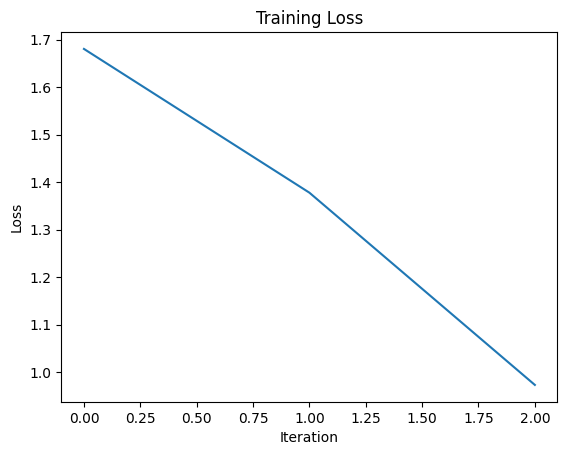

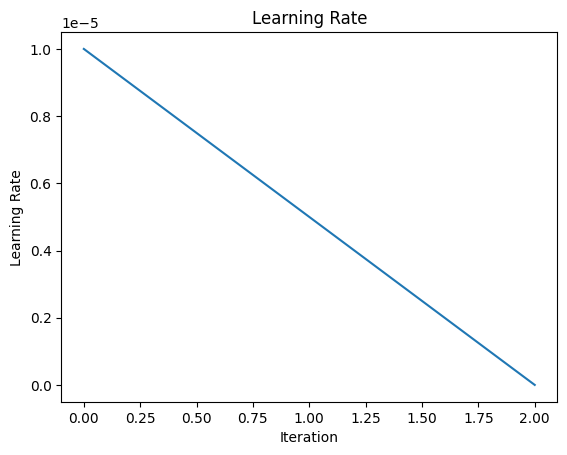

In [174]:
plot_loss(metrics_collector.metrics)
plot_learning_rate(metrics_collector.metrics)

## Loss vs Iteration: Ideal Shape and Expectations

**Desired Shape:**

The ideal loss curve for training depicts a **downward trend**, indicating the model's improvement in minimizing the loss function over iterations. This signifies the model is learning the patterns in the data and making better predictions.

**Expected Behavior:**

* **Initial Rapid Decrease:** Early iterations often show a steep decline as the model grasps basic patterns.
* **Gradual Descent:** As the model encounters more complex relationships, the decrease becomes slower and steadier.
* **Plateau (Optional):** In some cases,  the loss may reach a plateau, indicating the model has achieved its optimal performance with the current hyperparameters.

**Warning Signs:**

* **Stagnation:** If the loss remains flat from the beginning, the model might not be learning effectively. This could be due to factors like insufficient data, inappropriate model architecture, or high learning rate.
* **Oscillation:** Erratic fluctuations can indicate the model is overfitting to the training data. Techniques like regularization or reducing learning rate can help.

## Learning Rate vs Iteration: Ideal Behavior and Expectations

**Desired Behavior:**

The learning rate can be adjusted throughout training using a learning rate schedule. Here are some common approaches:

* **Constant Learning Rate:** A simple approach, but may not be optimal for all scenarios.
* **Step Decay:** Learning rate is reduced by a fixed amount at specific intervals (epochs).
* **Exponential Decay:** Learning rate decreases exponentially over time.
* **Warm Restarts:** Learning rate is periodically increased to a higher value, allowing the model to escape local minima.

**General Expectations:**

* The learning rate should be high enough for the model to learn effectively initially.
* A gradual decrease in learning rate helps the model converge to a minimum more precisely.
* Choosing the right learning rate schedule depends on the specific problem and dataset.

**Warning Signs:**

* **Too High Learning Rate:** Can lead to large oscillations or divergence in the loss curve.
* **Too Low Learning Rate:** Slows down training significantly and may prevent the model from reaching optimal performance.

By monitoring both loss and learning rate curves, you can gain valuable insights into the training process and adjust hyperparameters for better results.

**Additional Tips:**

* Use validation loss to track generalization performance and avoid overfitting.
* Experiment with different learning rate schedules to find the best fit for your problem.
* Consider techniques like early stopping to prevent overfitting when the validation loss starts to increase.


### Save model locally

In [175]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: ai_medical_3_steps/final


In [176]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)


In [177]:
finetuned_slightly_model.to(device) 


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Run slightly trained model

In [178]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)
print("Finetuned slightly model's answer: ")
print(inference_new(test_question, finetuned_slightly_model, tokenizer))

Question input (test): ### Question:
Will Kalarchikai cure multiple ovarian cysts in PCOD?
### Answer:
Finetuned slightly model's answer: 
Hi. Kalarikai is a good medicine for ovarian cysts. It is a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine


In [179]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)



Target answer output (test): Hello. I just read your query. See Kalarachi Kai choornam is helpful in amenorrhea. As far as small cysts are concerned they are unmatured eggs which failed to induce menstrual cycle previously, as a result, they got collected in the ovary and they will remain in the ovary. Now, you have got your periods you can start trying for conception. But I advise you to do it under the supervision of a nearby gynecologist because egg size is important while conception and that you can know by ovulation study. Ovulation study is performed under the supervision of a gynecologist. For gall stones, surgical intervention is required generally. Medicine is not of much help.


### Run same model trained for two epochs 

In [41]:
#finetuned_longer_model = AutoModelForCausalLM.from_pretrained("ruslanmv/ai-medical-chatbot-finetuned")
#tokenizer = AutoTokenizer.from_pretrained("ruslanmv/ai-medical-chatbot-finetuned")
#finetuned_longer_model.to(device)
#print("Finetuned longer model's answer: ")
#print(inference_new(test_question, finetuned_longer_model, tokenizer))

### Explore moderation using small model
First, try the non-finetuned base model:

In [180]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference_new("What do you think of Mars?", base_model, base_tokenizer))



I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I think I’m going to go to the next page.

I


### Now try moderation with finetuned small model 

In [181]:
#print(inference_new("What do you think of Mars?", finetuned_longer_model, tokenizer))
print(inference_new("What do you think of Mars?", finetuned_slightly_model, tokenizer))


I’m not sure if you are a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be a good enough person to be


In [43]:
## Comparison 

In [182]:
import pandas as pd

# Assuming test_dataset is already loaded
test_questions = [test_dataset[i]['question'] for i in range(len(test_dataset))]


In [183]:
len(test_questions[:10])

10

In [184]:

# Load the base model and tokenizer
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")


In [185]:

# Function to get the model's answer
def get_answer(question, model, tokenizer):
    return inference_new(question, model, tokenizer)


In [186]:
from tqdm import tqdm  # Import tqdm for progress bar

In [187]:
# Iterate through the test questions and generate answers using both models
results = []
for question in tqdm(test_questions[:10]): #test_questions:
    finetuned_answer = get_answer(question, finetuned_slightly_model, tokenizer)
    base_answer = get_answer(question, base_model, base_tokenizer)
    result = {'question': question, 'trained model': finetuned_answer, 'Base Model': base_answer}
    results.append(result)


100%|██████████| 10/10 [00:30<00:00,  3.00s/it]


In [188]:
# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame.from_dict(results)

# Style the DataFrame for better readability
style_df = df.style.set_properties(**{'text-align': 'left'})
style_df = style_df.set_properties(**{"vertical-align": "text-top"})

# Display the DataFrame
style_df

,question,trained model,Base Model
0,### Question: Will Kalarchikai cure multiple ovarian cysts in PCOD? ### Answer:,"Hi. Kalarikai is a good medicine for ovarian cysts. It is a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine for ovarian cysts. But, it is not a good medicine","The answer is ""Yes"" and ""No"" The answer is ""Yes"" and ""No"" The answer is ""Yes"" and ""No"" The answer is ""Yes"" and ""No"" The answer is ""Yes"" and ""No"" The answer is ""Yes"" and ""No"" The answer is ""Yes"
1,### Question: Why is blood pressure normal in the morning but increases at night? ### Answer:,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> ### Answer:Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> ### Answer:Hi. I have gone,Why is blood pressure normal in the morning? ### Answer: Why is blood pressure normal in the morning? ### Answer: Why is blood pressure normal in the morning? ### Answer: Why is blood pressure normal in the morning? ### Answer: Why is blood pressure normal in the morning? ### Answer: Why is
2,### Question: Do I have osteoarthritis? ### Answer:,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi. For further,"Yes, I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis. I have osteoarthritis."
3,### Question: I masturbate only by rubbing the tip of the penis. Is it a wrong way? ### Answer:,Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ###,I masturbate only by rubbing the tip of the penis. Is it a wrong way? ### Answer: I masturbate only by rubbing the tip of the penis. Is it a wrong way? ### Answer: I masturbate only by rubbing the tip of the penis. Is it a wrong way? ### Answer:
4,### Question: How can I manage dysfunctional pancreas? ### Answer:,Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi. For further doubts consult a neurologist online --> ### Answer:Hi.,How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer: How can I manage the pancreas? ### Answer:
5,### Question: I masturbate only by rubbing the tip of the penis. Is it a wrong way? ### Answer:,Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ### Answer:Hi. For further doubts consult a sexologist online --> ###,I masturbate only by rub